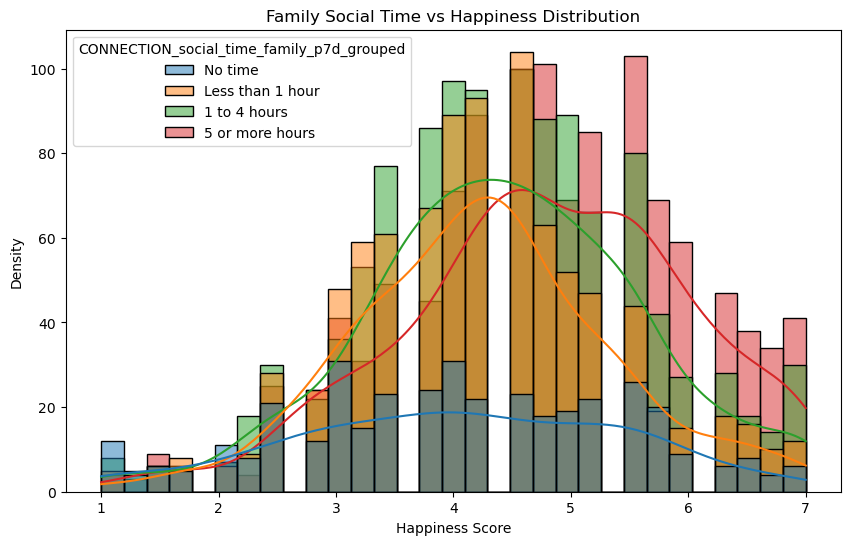

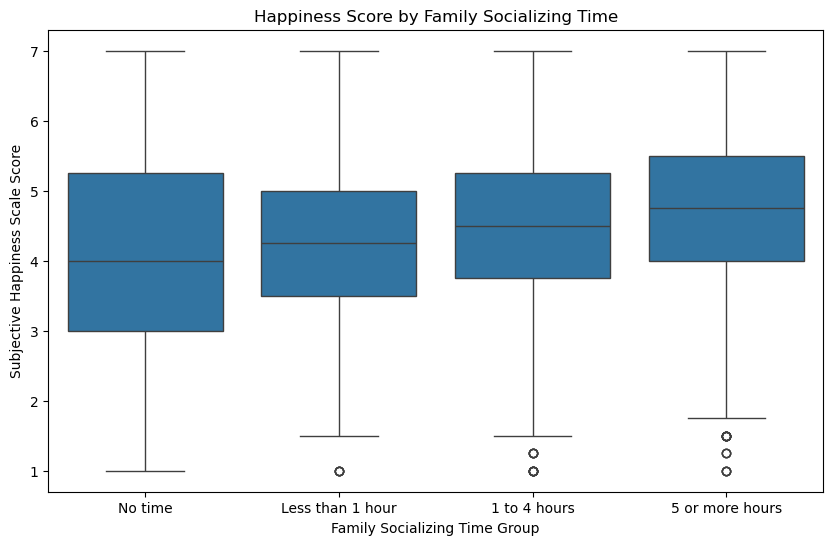

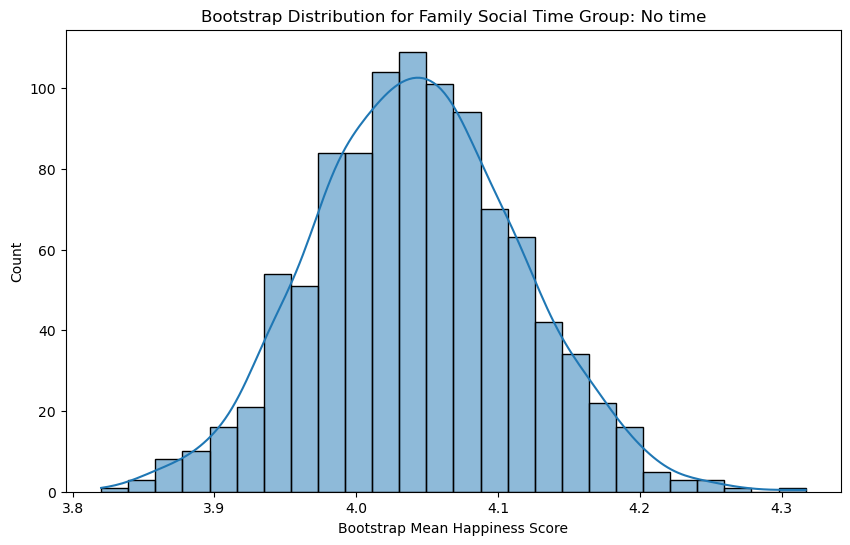

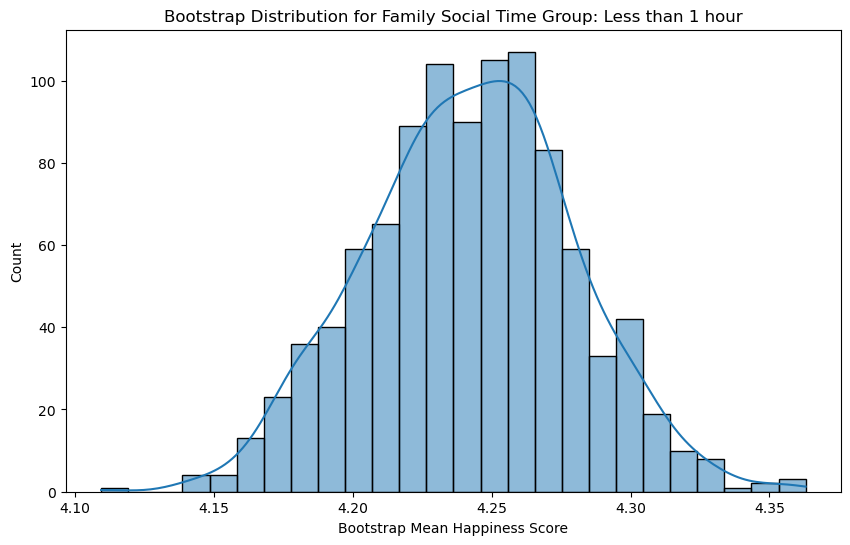

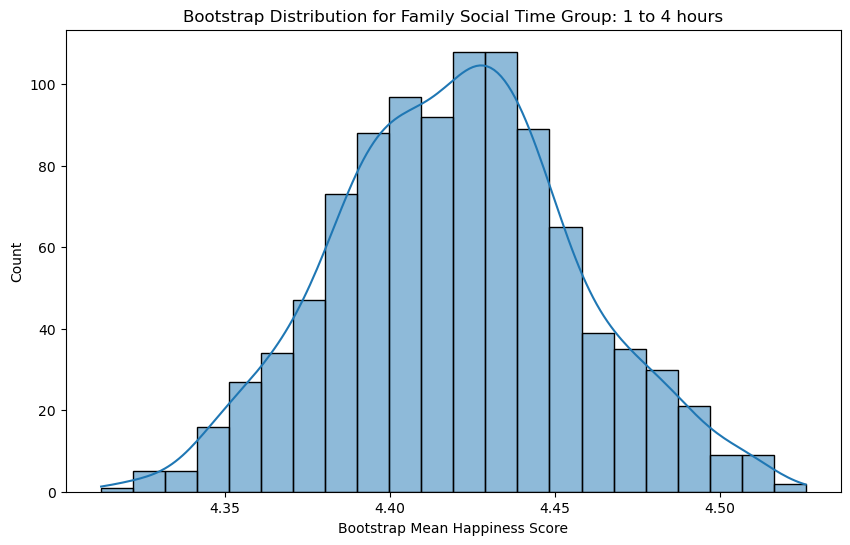

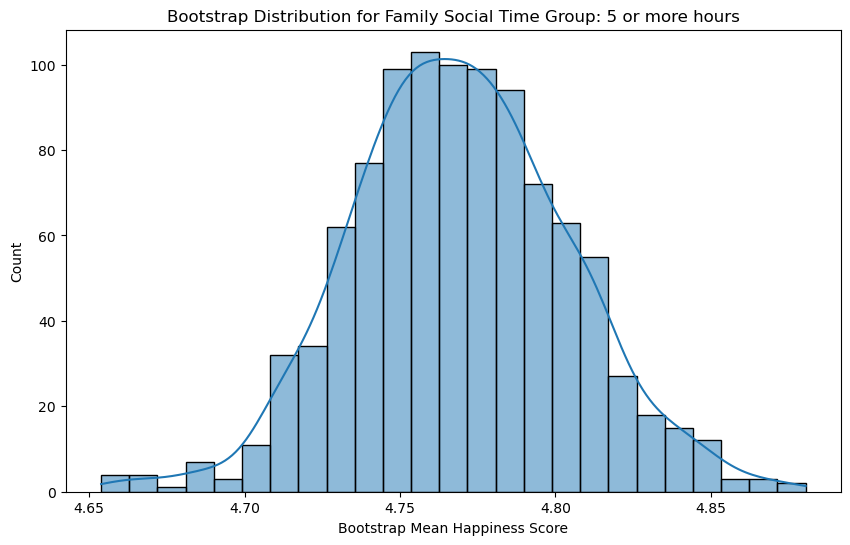

95% Confidence Interval for No time: (3.90, 4.19)
95% Confidence Interval for Less than 1 hour: (4.17, 4.31)
95% Confidence Interval for 1 to 4 hours: (4.35, 4.50)
95% Confidence Interval for 5 or more hours: (4.71, 4.84)
95% Confidence Interval for overall data: (4.40, 4.49)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv", low_memory=False)

# Filter out rows where family social time response is 'Presented but no response'
df_filtered = df.loc[df['CONNECTION_social_time_family_p7d_grouped'] != 'Presented but no response'].copy()

# Sort family social time from least to most
sorted_order = ['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours']
df_filtered['CONNECTION_social_time_family_p7d_grouped'] = pd.Categorical(df_filtered['CONNECTION_social_time_family_p7d_grouped'], categories=sorted_order, ordered=True)
df_filtered = df_filtered.sort_values('CONNECTION_social_time_family_p7d_grouped')

# Drop any NaN values that may be present
df_filtered = df_filtered[['CONNECTION_social_time_family_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Data Visualization
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='WELLNESS_subjective_happiness_scale_score', hue='CONNECTION_social_time_family_p7d_grouped', kde=True)
plt.xlabel('Happiness Score')
plt.ylabel('Density')
plt.title('Family Social Time vs Happiness Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='CONNECTION_social_time_family_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score')
plt.xlabel('Family Socializing Time Group')
plt.ylabel('Subjective Happiness Scale Score')
plt.title('Happiness Score by Family Socializing Time')
plt.show()

# Bootstrapping for each family social time group
n_iterations = 1000
group_means = df_filtered.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].mean()

bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = df_filtered.sample(frac=1, replace=True)
    bootstrap_group_means = bootstrap_sample.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].mean()
    bootstrap_means.append(bootstrap_group_means)

# Plotting Bootstrap Means for each Group
for group in sorted_order:
    group_bootstrap_means = [bm[group] for bm in bootstrap_means]
    plt.figure(figsize=(10, 6))
    sns.histplot(group_bootstrap_means, kde=True)
    plt.xlabel('Bootstrap Mean Happiness Score')
    plt.title(f'Bootstrap Distribution for Family Social Time Group: {group}')
    plt.show()

# Confidence Intervals for each group
for group in sorted_order:
    group_bootstrap_means = [bm[group] for bm in bootstrap_means]
    lower_ci = np.percentile(group_bootstrap_means, 2.5)
    upper_ci = np.percentile(group_bootstrap_means, 97.5)
    print(f"95% Confidence Interval for {group}: ({lower_ci:.2f}, {upper_ci:.2f})")

# Bootstrapping for overall data
overall_bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = df_filtered['WELLNESS_subjective_happiness_scale_score'].sample(frac=1, replace=True)
    overall_bootstrap_means.append(bootstrap_sample.mean())

# Confidence Interval for overall data
overall_lower_ci = np.percentile(overall_bootstrap_means, 2.5)
overall_upper_ci = np.percentile(overall_bootstrap_means, 97.5)
print(f"95% Confidence Interval for overall data: ({overall_lower_ci:.2f}, {overall_upper_ci:.2f})")


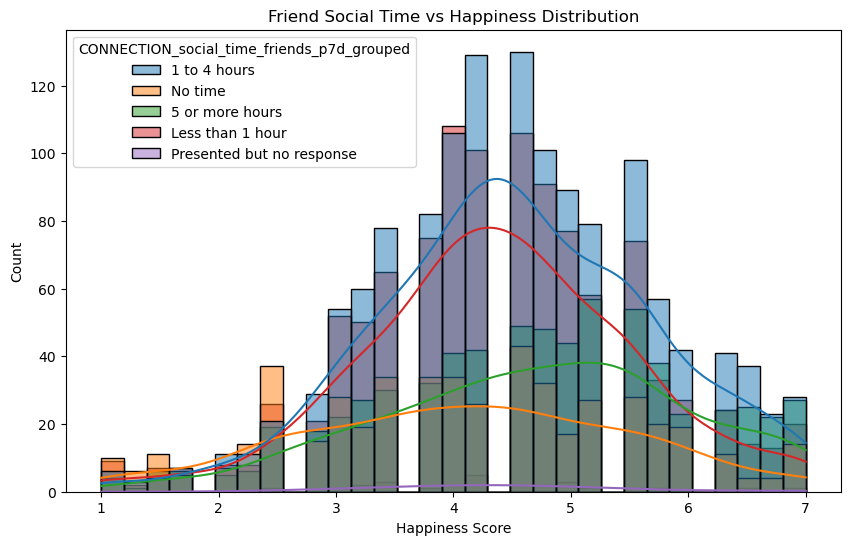

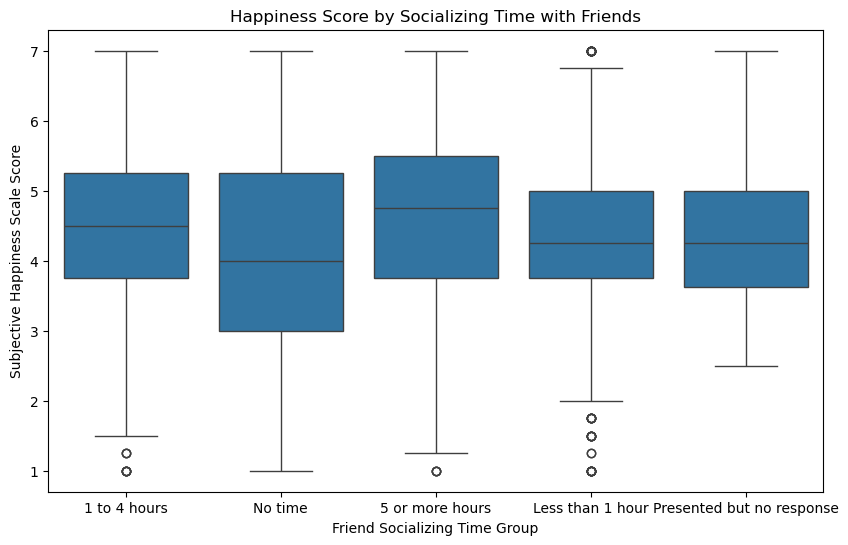


P-values for each friend socialising time group:
{'1 to 4 hours': 0.514, '5 or more hours': 0.527, 'Less than 1 hour': 0.501, 'No time': 0.481, 'Presented but no response': 0.504}


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)

# Filter relevant columns
friends_data = data[['CONNECTION_social_time_friends_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Convert categorical variable into numerical values
label_encoder = LabelEncoder()
friends_data['social_time_encoded'] = label_encoder.fit_transform(friends_data['CONNECTION_social_time_friends_p7d_grouped'])

# Data visualization
plt.figure(figsize=(10, 6))
sns.histplot(friends_data, x='WELLNESS_subjective_happiness_scale_score', hue='CONNECTION_social_time_friends_p7d_grouped', kde=True)
plt.xlabel('Happiness Score')
plt.title('Friend Social Time vs Happiness Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=friends_data, x='CONNECTION_social_time_friends_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score')
plt.xlabel('Friend Socializing Time Group')
plt.ylabel('Subjective Happiness Scale Score')
plt.title('Happiness Score by Socializing Time with Friends')
plt.show()

# Perform bootstrapping for hypothesis testing
n_iterations = 1000
observed_means = friends_data.groupby('CONNECTION_social_time_friends_p7d_grouped')['WELLNESS_subjective_happiness_scale_score'].mean()

bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = friends_data.sample(frac=1, replace=True)
    bootstrap_group_means = bootstrap_sample.groupby('CONNECTION_social_time_friends_p7d_grouped')['WELLNESS_subjective_happiness_scale_score'].mean()
    bootstrap_means.append(bootstrap_group_means)

# Test statistics
p_values = {}
for group in observed_means.index:
    greater_count = sum([bm[group] > observed_means[group] for bm in bootstrap_means])
    p_values[group] = greater_count / n_iterations

print("\nP-values for each friend socialising time group:")
print(p_values)



Classification Tree for Neighbours Social Time:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       571
           1       0.58      0.22      0.32       509

    accuracy                           0.56      1080
   macro avg       0.57      0.54      0.50      1080
weighted avg       0.57      0.56      0.51      1080

Accuracy Score: 0.5574074074074075


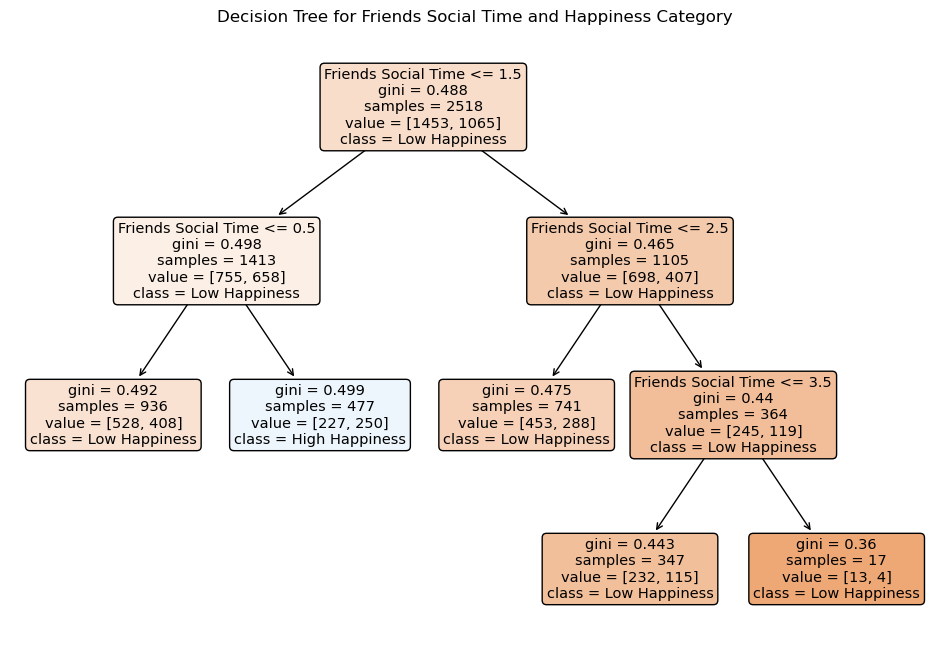

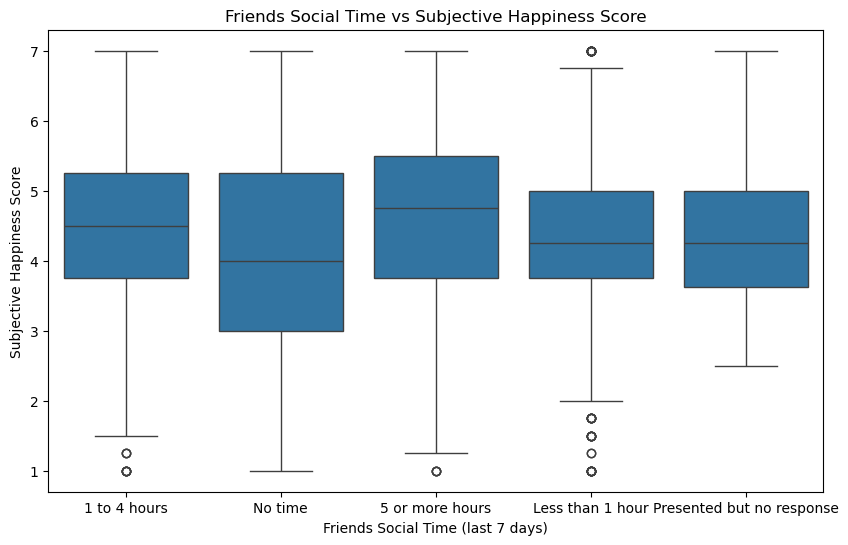

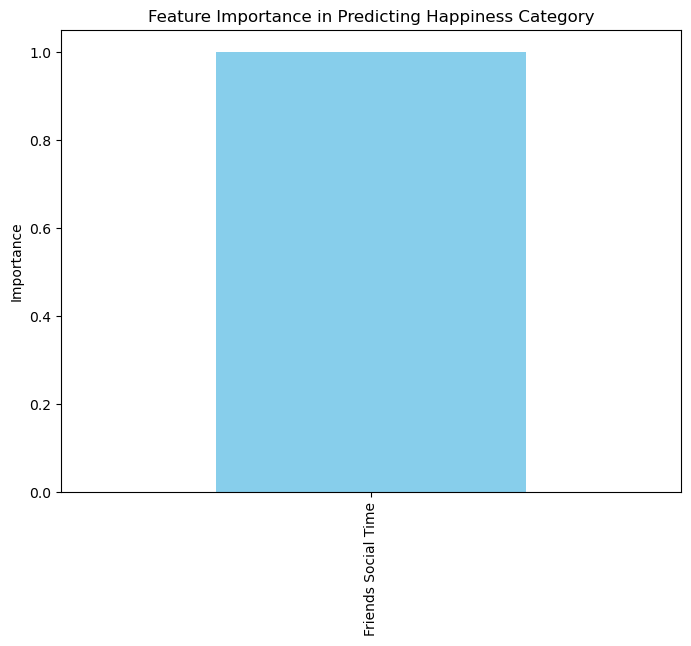

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)

# Filter relevant columns
neighbours_data = data[['CONNECTION_social_time_neighbours_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Convert categorical variable into numerical values
label_encoder = LabelEncoder()
friends_data['social_time_encoded'] = label_encoder.fit_transform(friends_data['CONNECTION_social_time_friends_p7d_grouped'])

# Add a classification tree
threshold = friends_data['WELLNESS_subjective_happiness_scale_score'].median()
friends_data['happiness_category'] = (friends_data['WELLNESS_subjective_happiness_scale_score'] > threshold).astype(int)

X = friends_data[['social_time_encoded']].values  # Use the encoded column for training
y = friends_data['happiness_category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nClassification Tree for Neighbours Social Time:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['Friends Social Time'], class_names=['Low Happiness', 'High Happiness'], filled=True, rounded=True) 
plt.title("Decision Tree for Friends Social Time and Happiness Category") 
plt.show()

# Step 4: Additional visualization
# Visualize the relationship between social time with friends and subjective happiness
plt.figure(figsize=(10, 6))
sns.boxplot(x='CONNECTION_social_time_friends_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score', data=friends_data)
plt.xlabel('Friends Social Time (last 7 days)')
plt.ylabel('Subjective Happiness Score')
plt.title('Friends Social Time vs Subjective Happiness Score')
plt.show()

# Visualize feature importance
feature_importance = pd.Series(clf.feature_importances_, index=['Friends Social Time'])
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.ylabel('Importance')
plt.title('Feature Importance in Predicting Happiness Category')
plt.show()
